In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
from TargetDistributions.Mueller_potential import MuellerPotential
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

In [5]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_many_well(*args, **kwargs)
    plt.show()

In [6]:
dim = 2
target = MuellerPotential()

In [7]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

# Vanilla IS

In [8]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
    print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
          var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

ESS is 0.0005004851322789716,           var is 1.997261077993118e-05


# DReG likelihood

In [13]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type=False, n_distributions=20, n_steps_transition_operator=3,
                    step_size=1.0, transition_operator="HMC", learnt_dist_kwargs={"lr": 1e-4},
                     loss_type_2="alpha_2")

In [14]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.00012147167203899485


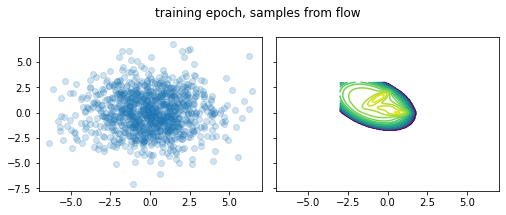

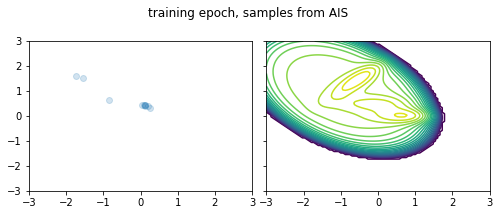

In [15]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

  0%|                                                                                                                                                          | 0/500 [00:00<?, ?it/s]

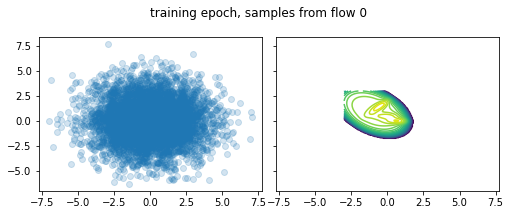

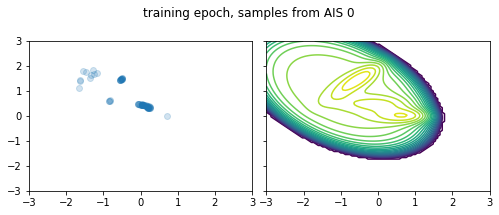

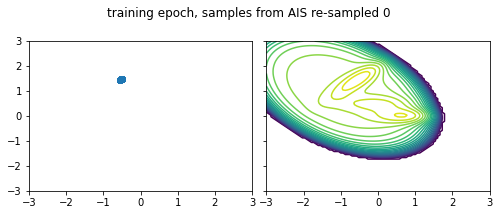

loss: 297.69153859647,   log_p_x_post_AIS -109.30773286246475, ESS 0.0010710910716360948:  10%|████▉                                            | 50/500 [2:14:41<21:32:28, 172.33s/it]

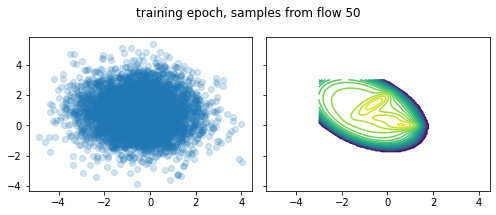

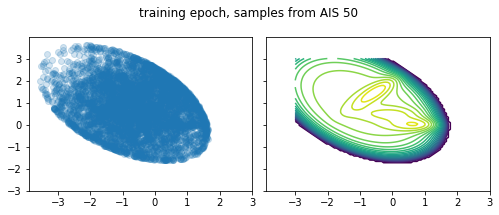

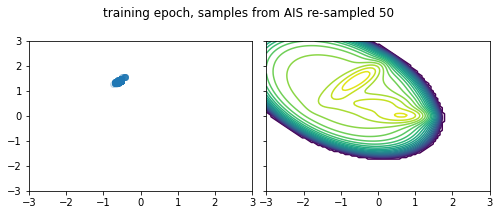

loss: 297.20667255169235,   log_p_x_post_AIS -70.03234482430187, ESS 0.0022953277093888964:  20%|█████████▏                                    | 100/500 [4:56:32<22:06:17, 198.94s/it]

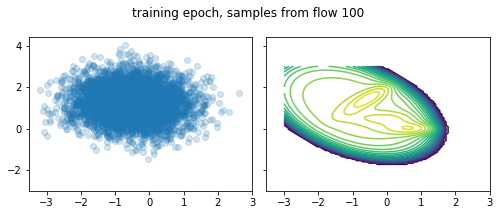

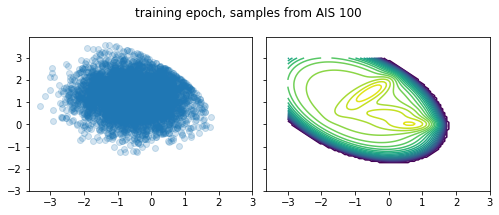

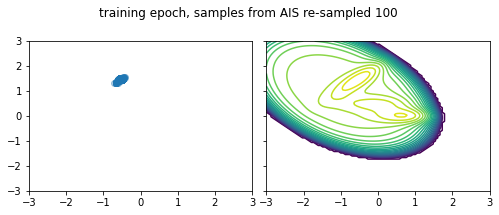

loss: 296.35043840907144,   log_p_x_post_AIS 137.81721865873982, ESS 0.20860024894538914:  30%|██████████████▍                                 | 150/500 [7:44:41<19:45:26, 203.22s/it]

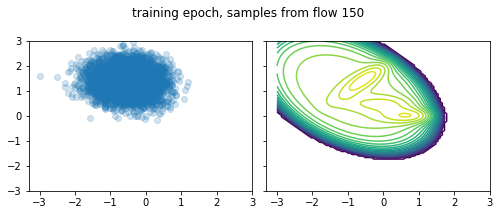

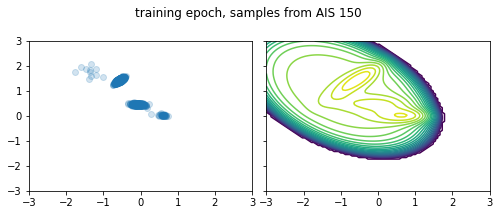

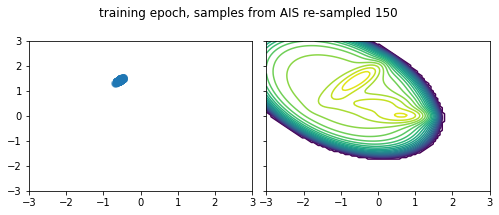

loss: 296.05587466146403,   log_p_x_post_AIS 142.5713722167853, ESS 0.22399092816157617:  34%|████████████████▍                                | 168/500 [8:43:56<17:15:24, 187.12s/it]


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:75] data. DefaultCPUAllocator: not enough memory: you tried to allocate 160000 bytes. Buy new RAM!

In [16]:
history = tester.train(500, batch_size=int(1e3), intermediate_plots=True, n_plots=10, plotting_func=plotter)

In [ ]:
plot_history(history)

In [ ]:
plot_history(dict([(key, history[key]) for key in ('loss', 'log_p_x_after_AIS', 'log_w', 'kl', 
                                               'alpha_2_divergence', 'log_q_AIS_x', 'ESS')]))

In [ ]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

In [ ]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])